# Importing Libraries

In [2]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt 
from scipy.optimize import minimize

# Setting Working Directory

In [4]:
os.chdir(r'C:\Users\HP\Desktop\wsm_project')
os.getcwd()

'C:\\Users\\HP\\Desktop\\wsm_project'

# Importing Data in Dataframe

In [6]:
df = pd.read_csv("WRIS_ABCD_model_INPUT_DATA.csv")
y = df["Flow"]     # y is the actual dependent variable (streamflow here)
SMo = 50           # initialization of state variables SMo and GWo of the abcd model
GWo = 300

# DEFINE ABCD MODEL 

In [8]:
def abcd(params, df, init_SM , init_GW):

    a, b, c , d = params               
    
    n = df.shape[0]   # n = number of datapoints in the dataset
    
    df1 = pd.DataFrame(columns=["Available Water W(t)","ET Opportunity Y(t)","E(t)", "SM(t)"]).astype(float)   # define a new dataframe for calcualtions

     # filling the dataframe df1 with the help of model equations

    # defining first values of each variable in df1 considering SMo and GWo 
    df1.loc[0,"Available Water W(t)"] = SMo + df.loc[0,"Rainfall"] 
    df1.loc[0, "ET Opportunity Y(t)"] = ((df1.loc[0, "Available Water W(t)"] + b) / (2 * a)) - (np.sqrt(((df1.loc[0, "Available Water W(t)"] + b) / (2 * a)) ** 2 - ((b * df1.loc[0, "Available Water W(t)"]) / (a))))
    df1.loc[0, "E(t)"] = np.min([(df1.loc[0, "ET Opportunity Y(t)"])*(1-(np.exp((- df.loc[0,"PET"])/(b)))), df.loc[0, "PET"]])
    df1.loc[0,"SM(t)"] = df1.loc[0,"ET Opportunity Y(t)"] - df1.loc[0,"E(t)"]
    df1.loc[0, "GW(t)"] = (1/(1+d))*(GWo + (c)*((df1.loc[0,"Available Water W(t)"]) - (df1.loc[0, "ET Opportunity Y(t)"])))
    df1.loc[0, "FLOW_PRED"] = (1-c)*(df1.loc[0,"Available Water W(t)"] - df1.loc[0, "ET Opportunity Y(t)"]) + (d)*(df1.loc[0, "GW(t)"])


    # now filling rest of the values for the variables in df1
    i = 1
    for i in range(1, n) :
    
        df1.loc[i, "Available Water W(t)"] = df1.loc[i-1, "SM(t)"] + df.loc[i,"Rainfall"] 
        df1.loc[i, "ET Opportunity Y(t)"] = ((df1.loc[i, "Available Water W(t)"] + b) / (2 * a) - np.sqrt(((df1.loc[i, "Available Water W(t)"] + b) / (2 * a)) ** 2 - (b * df1.loc[i, "Available Water W(t)"]) / a))
        df1.loc[i, "E(t)"] = np.min([(df1.loc[i, "ET Opportunity Y(t)"])*(1-(np.exp((- df.loc[i,"PET"])/(b)))), df.loc[i, "PET"]])
        df1.loc[i, "SM(t)"] = df1.loc[i,"ET Opportunity Y(t)"] - df1.loc[i,"E(t)"]
        df1.loc[i, "GW(t)"] = (1/(1+d))*((df1.loc[i-1, "GW(t)"]) + (c)*((df1.loc[i,"Available Water W(t)"]) - (df1.loc[i, "ET Opportunity Y(t)"])))
        df1.loc[i, "FLOW_PRED"] = (1-c)*(df1.loc[i,"Available Water W(t)"] - df1.loc[i, "ET Opportunity Y(t)"]) + (d)*(df1.loc[i, "GW(t)"])

    data  = pd.concat([df, df1], axis=1)
    predit_flow = data["FLOW_PRED"]
    max_Y = data["ET Opportunity Y(t)"].max()

    file_path = 'ABCD_MODEL_RESULTS.csv'  #save dataframe as a csv file
    data.to_csv(file_path, index=True)
   
    return predit_flow , max_Y, file_path


# Define minimizing function (mse HERE)

In [10]:
def mse(params, df ):
    y_pred , max_Y, file_path = abcd(params, df, SMo, GWo) 
    MSE = ((y_pred - y) ** 2).mean()
    return MSE


# Define constraints

In [12]:
# Define constraints

def constraint_lower_bound1(params):
    return params[0] - 0.1          # This ensures a >= 0.1

def constraint_upper_bound1(params):
    return 1 - params[0]              # This ensures a <= 1

def constraint_lower_bound3(params):
    return params[2] - 0.01  # This ensures c >= 0.001

def constraint_upper_bound3(params):
    return 1 - params[2]  # This ensures c <= 1

def constraint_lower_bound4(params):
    return params[3] - 0.0000001  # This ensures d >= 0.0000001

def constraint_upper_bound4(params):
    return 1 - params[3]  # This ensures d <= 1

def constraint2(params):
    y_pred , max_Y, file_path = abcd(params, df, SMo, GWo) 
    return params[1] - max_Y                                     # parameter b should be >= max_Y
    

constraints = [
    {'type': 'ineq', 'fun': constraint_lower_bound1},
    {'type': 'ineq', 'fun': constraint_upper_bound1},
    {'type': 'ineq', 'fun': constraint_lower_bound3},
    {'type': 'ineq', 'fun': constraint_upper_bound3},
    {'type': 'ineq', 'fun': constraint_lower_bound4},
    {'type': 'ineq', 'fun': constraint_upper_bound4},
    {'type': 'ineq', 'fun': constraint2}
]


# Parameter estimation using optimization

In [14]:
initial_guess = [0.1,1200,0.1,0.1]
result = minimize(mse, initial_guess, args=(df,), method='SLSQP', constraints = constraints)   # USING MINIMIZING FUNCTION & SLSQP AS OPTIMIZATION METHOD
pars = result.x

In [15]:
print("Optimized Parameters:", pars)
print("MSE:", result.fun)

Optimized Parameters: [9.94361606e-01 1.89335189e+03 3.06208513e-01 1.00000000e-07]
MSE: 1689.2141584123594


# Visualization

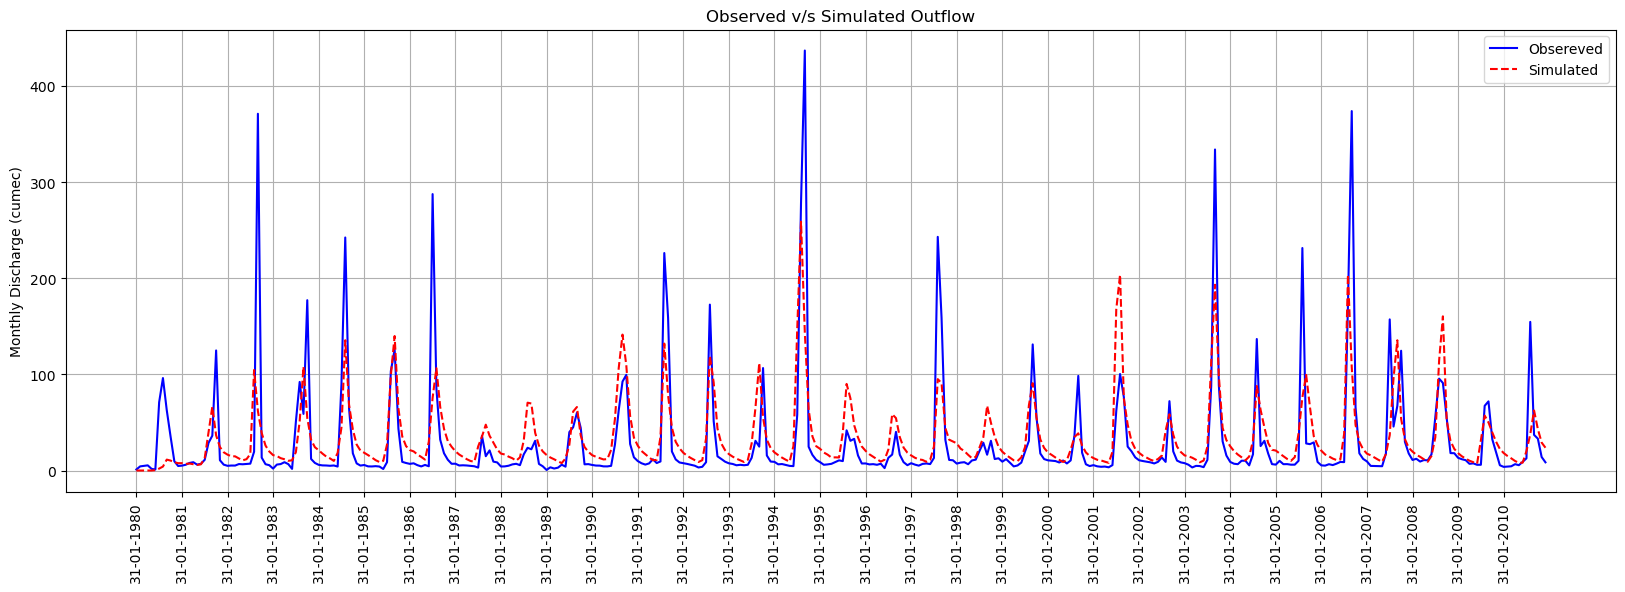

In [23]:
# now we visualize our result in form of a plot 
y_pred , max_Y, file_path = abcd(pars, df, SMo, GWo) 

# plotting two curves in one graph 

plt.figure(figsize = [20,6], dpi = 100)
plt.plot( df["Date"], y, color = "blue",  label = "Obsereved")      
plt.plot(df["Date"], y_pred, color = "red", linestyle = "dashed",label = "Simulated")
plt.xticks(df["Date"][::12],rotation=90)
plt.title("Observed v/s Simulated Outflow")

# labelling the x-ordinates
  

plt.ylabel('Monthly Discharge (cumec)')
plt.legend()
plt.grid()
plt.show()
